# interactive HALO tracks

This notebook shows how to plot the flight tracks of the HALO aircraft. First, we'll have only a quick look and later on we do some more work in order to get the data onto an interactive map.

## Preparations
First, we'll import pylab and the EUREC4A data catalog.

In [1]:
import eurec4a
cat = eurec4a.get_intake_catalog(use_ipfs="QmahMN2wgPauHYkkiTGoG2TpPBmj3p5FoYJAq9uE9iXT9N")

### Inspecting the dataset

In [2]:
ds = cat.HALO.BAHAMAS.PositionAttitude['HALO-0122'].to_dask()
ds

<xarray.Dataset>
Dimensions:     (time: 331760)
Coordinates:
    alt         (time) float32 dask.array<chunksize=(82940,), meta=np.ndarray>
    lat         (time) float64 dask.array<chunksize=(41470,), meta=np.ndarray>
    lon         (time) float64 dask.array<chunksize=(41470,), meta=np.ndarray>
  * time        (time) datetime64[ns] 2020-01-22T14:57:36 ... 2020-01-23T00:1...
Data variables:
    heading     (time) float32 dask.array<chunksize=(82940,), meta=np.ndarray>
    pitch       (time) float32 dask.array<chunksize=(82940,), meta=np.ndarray>
    roll        (time) float32 dask.array<chunksize=(82940,), meta=np.ndarray>
    tas         (time) float32 dask.array<chunksize=(82940,), meta=np.ndarray>
    trajectory  <U4 ...
Attributes: (12/13)
    Conventions:        CF-1.7
    date_last_revised:  2020-4-16
    description:        10Hz subset based on DLR BAHAMAS data, processed by A...
    featureType:        trajectory
    file_created:       File created by M. Klingebiel (email: marcus.klingebi...
    flight_id:          HALO-0122
    ...                 ...
    instrument:         BAHAMAS
    mission:            EUREC4A
    platform:           HALO
    source_file:        HALO-DB_dataset7374_release1_EUREC4A_HALO_BAHAMAS10Hz...
    title:              EUREC4A position and attitude data
    version:            1.1

Just to have a better visual impression, we can create a quick overview plot of the data:

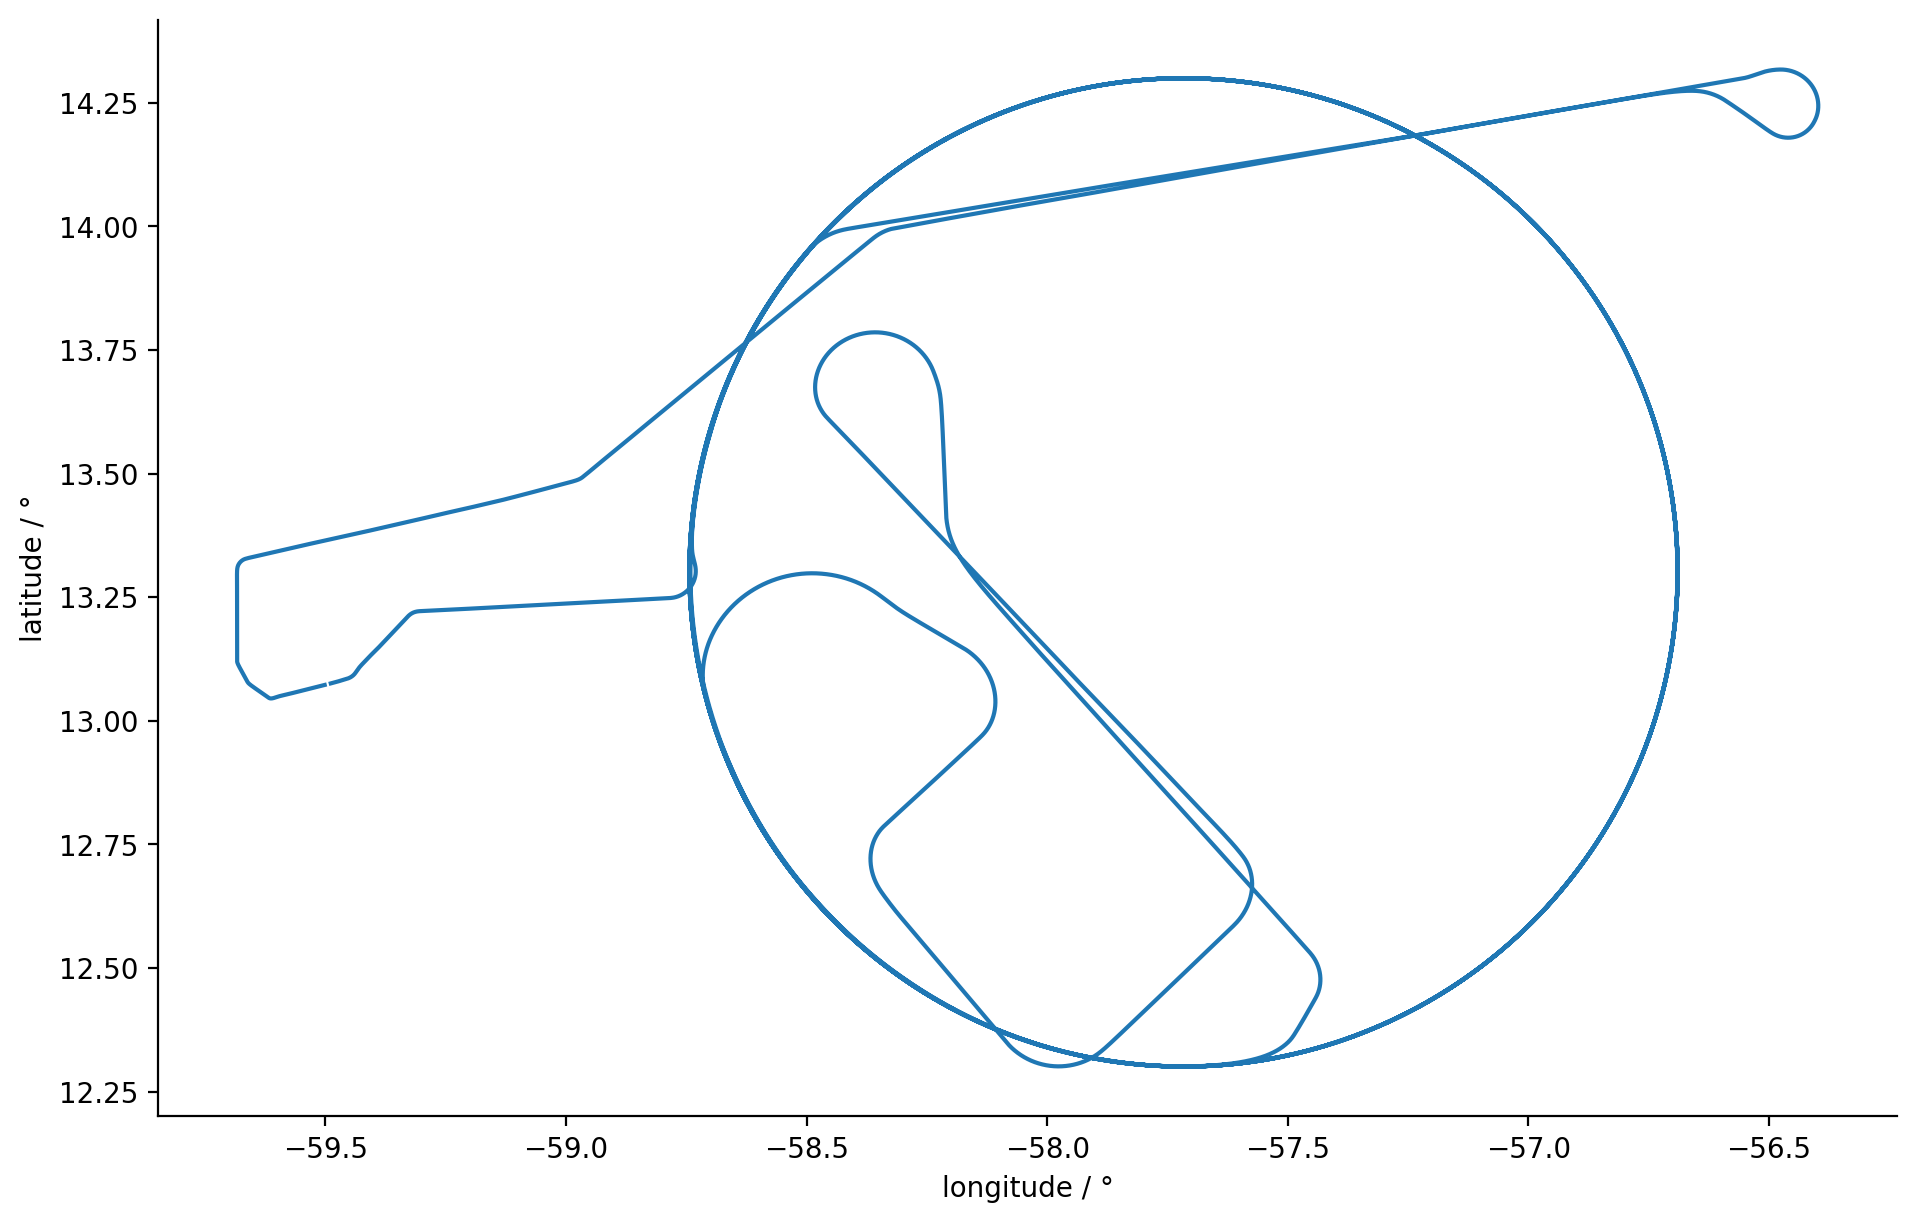

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pathlib
plt.style.use(pathlib.Path("./mplstyle/book"))

plt.plot(ds.lon, ds.lat)
center_lat = float(ds.lat.mean())
plt.gca().set_aspect(1./np.cos(np.deg2rad(center_lat)))
plt.xlabel("longitude / °")
plt.ylabel("latitude / °")
plt.show()

### Reducing the size of the dataset

Later on, we want to plot all flights on an interactive map. Currently the dataset is rather large as the aircraft location has been recorded continuously at a high data rate. While this is good for quantitative analysis, this leads to poor interactive performance. So before going further, it is a good idea to reduce the amount of data while keeping the visual impression.

A possible idea to reduce the amount of required data is that plotting a line already does linear interpolation between two coordinate points. So if we would remove those points which are close to the linear interpolation between its neighboring points, the visual impression will stay almost the same. This idea has already been stated by Ramer Douglas and Peucker and is illustrated at [Wikipedia](https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm). While the algorithm is not hard to write, it is difficult to do it efficiently in python. Thus, I've skipped it and use the [`simplification`](https://pypi.org/project/simplification/) library in stead.

```{note}
Many algorithms for shape processing are contained in the beautiful [shapely](https://shapely.readthedocs.io/en/stable/manual.html) library. In general, I'd recommend using that library, but it requies the GEOS library which is a bit tricky to install.
```

In [4]:
from simplification.cutil import simplify_coords_idx
def simplify_dataset(ds, tolerance):
    indices_to_take = simplify_coords_idx(np.stack([ds.lat.values, ds.lon.values], axis=1), tolerance)
    return ds.isel(time=indices_to_take)

We can now use that algorithm to generate a simplified version of the dataset with a tolerance of $10^{-5}$ degrees, which otherwise looks the same to the previous version.

In [5]:
dssimplified = simplify_dataset(ds, 1e-5)
dssimplified

<xarray.Dataset>
Dimensions:     (time: 8225)
Coordinates:
    alt         (time) float32 dask.array<chunksize=(2451,), meta=np.ndarray>
    lat         (time) float64 dask.array<chunksize=(1264,), meta=np.ndarray>
    lon         (time) float64 dask.array<chunksize=(1264,), meta=np.ndarray>
  * time        (time) datetime64[ns] 2020-01-22T14:57:36 ... 2020-01-23T00:1...
Data variables:
    heading     (time) float32 dask.array<chunksize=(2451,), meta=np.ndarray>
    pitch       (time) float32 dask.array<chunksize=(2451,), meta=np.ndarray>
    roll        (time) float32 dask.array<chunksize=(2451,), meta=np.ndarray>
    tas         (time) float32 dask.array<chunksize=(2451,), meta=np.ndarray>
    trajectory  <U4 ...
Attributes: (12/13)
    Conventions:        CF-1.7
    date_last_revised:  2020-4-16
    description:        10Hz subset based on DLR BAHAMAS data, processed by A...
    featureType:        trajectory
    file_created:       File created by M. Klingebiel (email: marcus.klingebi...
    flight_id:          HALO-0122
    ...                 ...
    instrument:         BAHAMAS
    mission:            EUREC4A
    platform:           HALO
    source_file:        HALO-DB_dataset7374_release1_EUREC4A_HALO_BAHAMAS10Hz...
    title:              EUREC4A position and attitude data
    version:            1.1

We can now compare those two tracks side by side while keeping a look at the number of data points required.

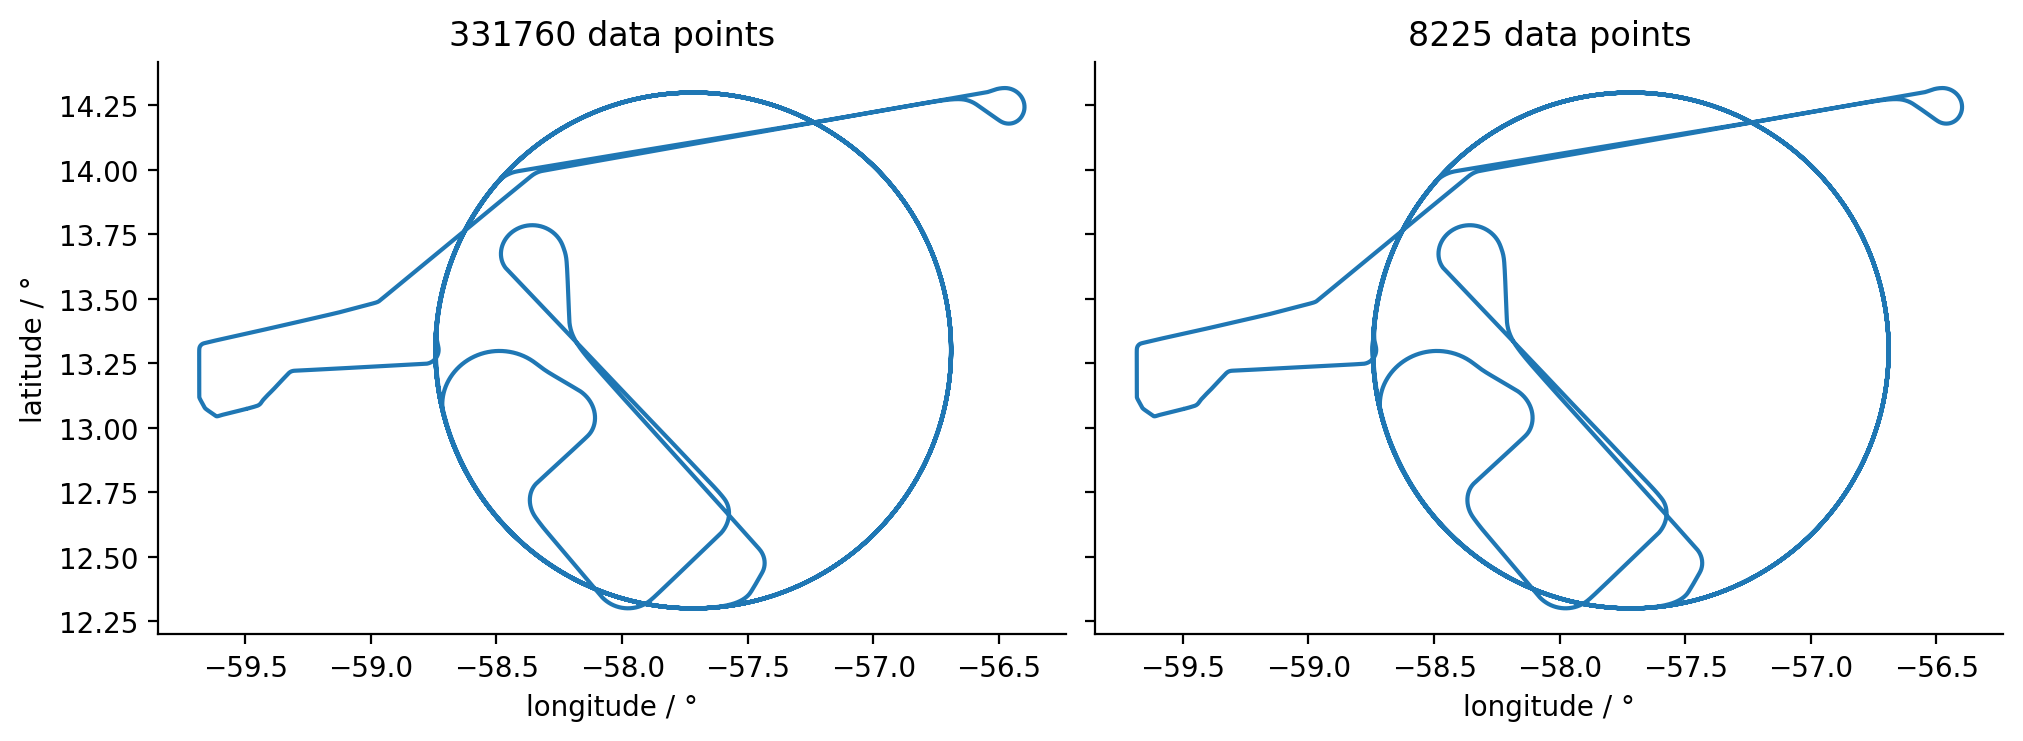

compression ratio: 2.48 %


In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(ds.lon, ds.lat)
ax1.set_title(f"{len(ds.time)} data points")
ax2.plot(dssimplified.lon, dssimplified.lat)
ax2.set_title(f"{len(dssimplified.time)} data points")

for ax in (ax1, ax2):
    ax.set_aspect(1./np.cos(np.deg2rad(center_lat)))
    ax.set_xlabel("longitude / °")
    ax.set_ylabel("latitude / °")
    ax.label_outer()


plt.show()

ratio = len(dssimplified.time) / len(ds.time)
print(f"compression ratio: {ratio*100:.2f} %")

The dataset size has been substantially reduced while the visual impression stayed the same.

## First interactive map

In order to show the map a little bit more interactively, we use the [`ipyleaflet`](https://ipyleaflet.readthedocs.io/en/latest/index.html) library which creates a bridge between ipython and the [Leaflet](https://leafletjs.com/) JavaScript library.

In [7]:
import ipyleaflet

As we will need to convert many tracks to ipyleaflet layers later on, the easiest is to create a little function for that purpose right away:

In [8]:
def track2layer(track, color="green", name=""):
    return ipyleaflet.Polyline(
        locations=np.stack([track.lat.values, track.lon.values], axis=1).tolist(), 
        color=color,
        fill=False,
        weight=2,
        name=name
    )

With the help of that little function, creating a map is now like a breeze:

In [9]:
testmap = ipyleaflet.Map(center=(13.3, -57), zoom=7)
testmap.add_layer(track2layer(dssimplified))
display(testmap)

Map(center=[13.3, -57], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

## All in one
Let's see if we can add all the flights and provide a layer switcher so that we can have a look at all flights individually. We'll start by loading and simplifying all out track data into a local dictionary. Requesting the datasets from the server is IO bound and thus can simply be accellerated using a ThreadPool:

In [10]:
def get_dataset(flight_id):
    ds = cat.HALO.BAHAMAS.PositionAttitude[flight_id].to_dask()
    return ds[['lat','lon']].load()

full_tracks = {k: get_dataset(k) for k in cat.HALO.BAHAMAS.PositionAttitude}

We still have to simplify the dataset, which is done here:

In [ ]:
tracks = {flight_id: simplify_dataset(ds, 1e-5)
          for flight_id, ds in full_tracks.items()}

Let's also quickly grab some colors from a matplotlib colorbar, such that we can show all tracks in individual colors:

In [ ]:
import matplotlib
colors = [matplotlib.colors.to_hex(c)
          for c in plt.cm.inferno(np.linspace(0, 1, len(tracks)))]

We can now start with a new empty map. Let's also have a different [basemap](https://ipyleaflet.readthedocs.io/en/latest/api_reference/basemaps.html).

In [ ]:
m = ipyleaflet.Map(
    basemap=ipyleaflet.basemaps.Esri.NatGeoWorldMap,
    center=(13.3, -57), zoom=7
)

We'll add all the tracks as individual layers to the map

In [ ]:
for (flight_id, track), color in zip(tracks.items(), colors):
    m.add_layer(track2layer(track, color, flight_id))

and add a scale, a legend, layer controls and a full screen button to the map and show it. If you want to zoom in, you can for example shift-click and drag a rectangle over the area you want to zoom in more closely.

In [ ]:
m.add_control(ipyleaflet.ScaleControl(position='bottomleft'))
m.add_control(ipyleaflet.LegendControl(dict(zip(tracks, colors)),
                                       name="Flights",
                                       position="bottomright"))
m.add_control(ipyleaflet.LayersControl(position='topright'))
m.add_control(ipyleaflet.FullScreenControl())
display(m)